### Loading and using the package

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import structcol as sc
import structcol.refractive_index as ri
from structcol import montecarlo as mc
from structcol import detector as det
from structcol import model
from structcol import structure
%matplotlib inline

plot the structure factor

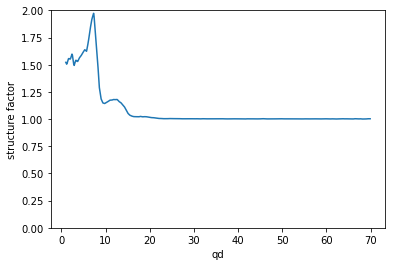

In [4]:
qd = np.arange(1,70, 0.1)# works up to qd = 72
s = structure.factor_data(qd)

plt.figure()
plt.plot(qd, s)
plt.ylim([0,2])
plt.xlabel('qd')
plt.ylabel('structure factor')

set parameters

In [9]:
ntrajectories = 2000                               # number of trajectories
nevents = 200                                     # number of scattering events in each trajectory
wavelengths = sc.Quantity(np.arange(400, 800, 20), 'nm') # wavelengths for scat calcs
radius = sc.Quantity('0.5 um')                  # particle radius
volume_fraction = sc.Quantity(0.5, '')            # volume fraction of particles
n_particle = ri.n('fused silica', wavelengths)
n_matrix = ri.n('vacuum', wavelengths)            # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelengths)            # space within sample. n_medium is outside the sample. 
                                                  # n_particle and n_matrix can have complex indices if absorption is desired
boundary = 'film'                       # geometry of sample, can be 'film' or 'sphere', see below for tutorial 
                                        # on sphere case
thickness = sc.Quantity('50 um') # thickness of the sample film

calculate reflectance

In [10]:
reflectance = np.zeros(wavelengths.size)
for i in range(wavelengths.size):
    
    # calculate n_sample
    n_sample = ri.n_eff(n_particle[i], n_matrix[i], volume_fraction)
    
    # Calculate the phase function and scattering and absorption coefficients from the single scattering model
    p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle[i], n_sample, volume_fraction, wavelengths[i], structure_type = 'data')
    
    # Initialize the trajectories
    r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium[i], n_sample, boundary)
    r0 = sc.Quantity(r0, 'um')
    k0 = sc.Quantity(k0, '')
    W0 = sc.Quantity(W0, '')
    
    # Generate a matrix of all the randomly sampled angles first 
    sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)
    
    # Create step size distribution
    step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)
        
    # Create trajectories object
    trajectories = mc.Trajectory(r0, k0, W0)
    
    # Run photons
    trajectories.absorb(mu_abs, step)                         
    trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
    trajectories.move(step)
    
    reflectance[i], transmittance = det.calc_refl_trans(trajectories, thickness, n_medium[i], n_sample, boundary)

/home/stephenson/Repositories/structural-color/structcol/detector.py:794: UserWarning:  
56.3% of trajectories did not exit the sample. Increase Nevents to improve accuracy.
  if stuck_frac >= 20: warnings.warn(stuck_traj_warn)
/home/stephenson/Repositories/structural-color/structcol/detector.py:794: UserWarning:  
55.45% of trajectories did not exit the sample. Increase Nevents to improve accuracy.
  if stuck_frac >= 20: warnings.warn(stuck_traj_warn)
/home/stephenson/Repositories/structural-color/structcol/detector.py:794: UserWarning:  
55.85% of trajectories did not exit the sample. Increase Nevents to improve accuracy.
  if stuck_frac >= 20: warnings.warn(stuck_traj_warn)
/home/stephenson/Repositories/structural-color/structcol/detector.py:794: UserWarning:  
53.75% of trajectories did not exit the sample. Increase Nevents to improve accuracy.
  if stuck_frac >= 20: warnings.warn(stuck_traj_warn)
/home/stephenson/Repositories/structural-color/structcol/detector.py:794: UserWarning

plot

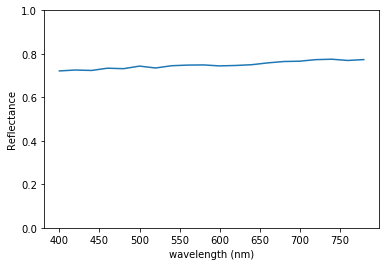

In [11]:
plt.figure()
plt.plot(wavelengths, reflectance)
plt.ylim([0,1])
plt.ylabel('Reflectance')
plt.xlabel('wavelength (nm)')